In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install konlpy
!pip install transformers
!pip install sentence-transformers
!pip install krwordrank
!pip install gensim
!pip install tensorflow

In [ ]:
import pandas as pd
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from transformers import BertTokenizer, BertForTokenClassification
import torch
from krwordrank.hangle import normalize
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from konlpy.tag import Komoran
from gensim.models import Word2Vec
import numpy as np

In [ ]:
df_sp = pd.read_csv('/content/drive/MyDrive/sports.csv')
df_e = pd.read_csv('/content/drive/MyDrive/entertain.csv')
df_ec = pd.read_csv('/content/drive/MyDrive/economy.csv')
df_i = pd.read_csv('/content/drive/MyDrive/IT.csv')
df_so = pd.read_csv('/content/drive/MyDrive/society.csv')
df_sp = pd.concat([df_sp['title'],df_sp['main']],axis = 1)
df_e = pd.concat([df_e['title'],df_e['main']],axis = 1)
df_ec = pd.concat([df_ec['title'],df_ec['main']],axis = 1)
df_i = pd.concat([df_i['title'],df_i['main']],axis = 1)
df_so = pd.concat([df_so['title'],df_so['main']],axis = 1)

In [ ]:
#불용어 제거
def clean_str(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s\n]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub('[-=+,<>..#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]',' ', string=text)
    text = re.sub('\n', ' ', string=text)
    return text 

In [ ]:
df_i['title'] = df_i['title'].apply(lambda x: clean_str(x))
df_i

In [ ]:
def KoBERT_vectorize(input_sentence):
    # Load KoBERT tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")
    model = AutoModel.from_pretrained("beomi/kcbert-base")

    # Tokenize the sentence
    tokens = tokenizer.tokenize(input_sentence)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension

    # Generate sentence embedding
    with torch.no_grad():
        outputs = model(input_ids)
        sentence_embedding = torch.mean(outputs.last_hidden_state, dim=1)
    
    return sentence_embedding

In [ ]:
def KoUSE_vectorize(input_sentence):
    # Load KoUSE model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate sentence embedding
    sentence_embedding = model.encode([input_sentence])
    
    return sentence_embedding

In [ ]:
mainList = []
# 스포츠랑 연예에서는 인덱스 값 수정해야함
for i in range(len(df_i)):
    mainList.append(df_i.iloc[i][1])

In [ ]:
vectorList = []
for i in range(len(df_i)):
    #(KoBERT_vectorize(df.iloc[i][0]))
    #(KoUSE_vectorize(df.iloc[i][0]))
    vectorList.append(KoUSE_vectorize(df_i.iloc[i][0])[0].tolist())

In [ ]:
# !pip install tensorflow==2.9.3
# !pip install h5py==3.1.0
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
# !pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
# from pykospacing import spacing

# df['content'] = df['content'].apply(lambda x: spacing(x))
# df

In [ ]:
# from hanspell import spell_checker

# df['content'] = df['content'].apply(lambda x: spell_checker.check(x))
# df

In [ ]:
keywords_IT = []

def extract_top_noun_phrase(news_article):
    
    # RoBERTa 모델과 토크나이저 로드
    model_name = "klue/roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # 형태소 분석기 초기화
    komoran = Komoran()

    # 명사구 추출
    nouns = komoran.nouns(news_article)
    noun_phrases = [noun for noun in nouns if len(noun) > 1]
    
    stop_words = "대체 자로 선수 부산 사진 기사 팀 동안 하다 되다 가다 이다 등 들 때문 그 또한 대해 많다 무엇 무슨 보다 못하다 모두 하다 있다 것 이 그것 저것 태 뉴스 차 은우 고 실패 생각 내 때 약 이후 등 확인 이 타점 재 입 그 것 전 문 공사 감독 한국 가스 를 기자 루 사 기회"
    stop_words = set(stop_words.split(' '))
    result = [word for word in noun_phrases if not word in stop_words]
    # RoBERTa 벡터화
    inputs = tokenizer(result, padding=True, truncation=True, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]  # CLS 토큰의 임베딩 추출

    # 기사 벡터화
    article_inputs = tokenizer([news_article], padding=True, truncation=True, return_tensors="pt")
    article_input_ids = article_inputs["input_ids"]
    article_attention_mask = article_inputs["attention_mask"]

    with torch.no_grad():
        article_outputs = model(article_input_ids, attention_mask=article_attention_mask)
        article_embedding = article_outputs.last_hidden_state[:, 0, :]  # CLS 토큰의 임베딩 추출

    # 유사도 계산
    similarities = cosine_similarity(article_embedding, embeddings).flatten()

    # 가장 유사한 명사구 추출
    most_similar_index = similarities.argmax()
    most_similar_noun_phrase = noun_phrases[most_similar_index]

    return most_similar_noun_phrase


#스포츠 연예에선 인덱스 바꿔야함
for i in range(len(df_i)):
    keywords_IT.append(extract_top_noun_phrase(df_i.iloc[i][0]))


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [ ]:
keywords_IT

['이통',
 '기술상',
 '오피스',
 '직영',
 '혜택',
 '6월',
 '요금',
 '혜택',
 '최강',
 '가입',
 '국산',
 '기술상',
 'AI',
 '철수',
 '금융',
 '할인',
 '가입자',
 '감사',
 '카카오',
 'LTE',
 '사회',
 '외톨이',
 '프로모션',
 '아이폰',
 '프로모션',
 '소속',
 '이젠 안녕',
 '월드',
 '요금',
 '종주국',
 '6월',
 '장병',
 '기술상',
 '산업',
 '더블',
 '운영전',
 '가입자',
 '소프트웨어',
 '인간',
 '한국판',
 '프로모션',
 '배재대',
 '혜택',
 '오피스']

In [ ]:
# Generate sample data
X = vectorList

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the autoencoder model
input_dim = X_scaled.shape[1] #384
encoding_dim = 2  # Reduced dimension for visualization
hidden_dim = 8

input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(hidden_dim, activation='relu')(input_layer)
encoding_layer = Dense(encoding_dim, activation='relu')(hidden_layer)
hidden_layer = Dense(hidden_dim, activation='relu')(encoding_layer)
output_layer = Dense(input_dim, activation='sigmoid')(hidden_layer)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

# Get the reduced-dimensional representations
encoder = Model(input_layer, encoding_layer)
encoded_data = encoder.predict(X_scaled)

# Perform clustering on the reduced-dimensional data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(encoded_data)

2/2 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


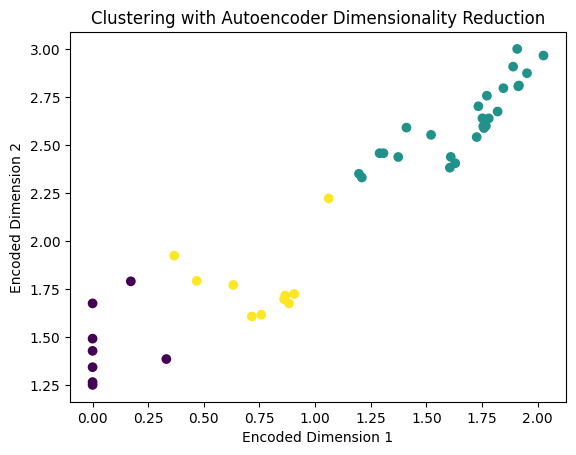

keywords: 이통 Cluster: 0
keywords: 기술상 Cluster: 0
keywords: 오피스 Cluster: 1
keywords: 직영 Cluster: 2
keywords: 혜택 Cluster: 1
keywords: 6월 Cluster: 2
keywords: 요금 Cluster: 1
keywords: 혜택 Cluster: 1
keywords: 최강 Cluster: 2
keywords: 가입 Cluster: 1
keywords: 국산 Cluster: 1
keywords: 기술상 Cluster: 1
keywords: AI Cluster: 1
keywords: 철수 Cluster: 2
keywords: 금융 Cluster: 1
keywords: 할인 Cluster: 2
keywords: 가입자 Cluster: 1
keywords: 감사 Cluster: 1
keywords: 카카오 Cluster: 0
keywords: LTE Cluster: 0
keywords: 사회 Cluster: 0
keywords: 외톨이 Cluster: 1
keywords: 프로모션 Cluster: 2
keywords: 아이폰 Cluster: 1
keywords: 프로모션 Cluster: 2
keywords: 소속 Cluster: 1
keywords: 이젠 안녕 Cluster: 1
keywords: 월드 Cluster: 0
keywords: 요금 Cluster: 1
keywords: 종주국 Cluster: 1
keywords: 6월 Cluster: 1
keywords: 장병 Cluster: 1
keywords: 기술상 Cluster: 1
keywords: 산업 Cluster: 1
keywords: 더블 Cluster: 1
keywords: 운영전 Cluster: 1
keywords: 가입자 Cluster: 2
keywords: 소프트웨어 Cluster: 0
keywords: 인간 Cluster: 0
keywords: 한국판 Cluster: 2
keywords: 프로모션 Cl

In [ ]:
# Generate sample data
X = vectorList

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the autoencoder model
input_dim = X_scaled.shape[1] #384
encoding_dim = 2  # Reduced dimension for visualization
hidden_dim = 8

input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(hidden_dim, activation='relu')(input_layer)
encoding_layer = Dense(encoding_dim, activation='relu')(hidden_layer)
hidden_layer = Dense(hidden_dim, activation='relu')(encoding_layer)
output_layer = Dense(input_dim, activation='sigmoid')(hidden_layer)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

# Get the reduced-dimensional representations
encoder = Model(input_layer, encoding_layer)
encoded_data = encoder.predict(X_scaled)

# Perform clustering on the reduced-dimensional data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(encoded_data)

# Plot the clusters
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering with Autoencoder Dimensionality Reduction')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()

for i in range(len(vectorList)):
    print("keywords:", keywords_IT[i], "Cluster:", clusters[i])

In [ ]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[0.06292617, 1.4527761 ],
       [1.6718576 , 2.626432  ],
       [0.7516637 , 1.7737522 ]], dtype=float32)

In [ ]:
encoded_data.tolist()

[[0.0, 1.6743953227996826],
 [0.1719283014535904, 1.7894002199172974],
 [1.725901484489441, 2.540790319442749],
 [0.8653784394264221, 1.715248703956604],
 [1.915804147720337, 2.8095569610595703],
 [0.7580311298370361, 1.6153086423873901],
 [2.026075601577759, 2.9656224250793457],
 [1.7590317726135254, 2.587679147720337],
 [0.36704742908477783, 1.9232087135314941],
 [1.8199265003204346, 2.6738626956939697],
 [1.3070149421691895, 2.456799268722534],
 [1.1969199180603027, 2.3495676517486572],
 [1.8896697759628296, 2.907782554626465],
 [0.6322727799415588, 1.7704013586044312],
 [1.7335385084152222, 2.701373338699341],
 [0.8608486652374268, 1.6957768201828003],
 [1.5209922790527344, 2.5524613857269287],
 [1.7803276777267456, 2.6383137702941895],
 [0.0, 1.2644013166427612],
 [0.3314816653728485, 1.3844772577285767],
 [0.0, 1.3421117067337036],
 [1.9079787731170654, 3.000054359436035],
 [0.9060634970664978, 1.7236989736557007],
 [1.6054004430770874, 2.3813676834106445],
 [0.7156139016151428, 

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
closest_points, _ = pairwise_distances_argmin_min(cluster_centers.tolist() ,encoded_data.tolist())
closest_points

array([27, 42, 13])

In [ ]:
hot_news = []
hot_keyword = []
for i in closest_points:
  hot_news.append(mainList[i])
  hot_keyword.append(keywords_IT[i])

In [ ]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration
tokenizer = PreTrainedTokenizerFast.from_pretrained("ainize/kobart-news")
model = BartForConditionalGeneration.from_pretrained("ainize/kobart-news")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
def text_summarize(news_text):
    input_ids = tokenizer.encode(news_text, return_tensors="pt")
    summary_text_ids = model.generate(
        input_ids=input_ids,
        bos_token_id=model.config.bos_token_id,
        eos_token_id=model.config.eos_token_id,
        length_penalty=1.0,
        max_length=128,
        min_length=64,
        num_beams=4)
    summary = tokenizer.decode(summary_text_ids[0],skip_special_tokens=True)
    return summary

In [ ]:
hot_keyword = []
hot_summary = []

In [ ]:
for i in range(len(hot_news)):
    hot_summary.append(text_summarize(hot_news[i]))    

In [ ]:
hot_summary

['한국전자통신연구원(ETRI)은 지난달 22일 영국 런던에서 AT&T, BT, NIT도코모 같은 세계적인 이동통신사와 에릭슨, 퀄컴, 마비니어를 비롯한 통신 장비 제조기업이 참여하는 세계 최고 수준의 이동통신 분야 행사인 ‘스몰셀 월드서밋(SCWS) 포럼’에서 스몰셀 기술로 최우수 기술상을 수상하며 국내 이동통신 기술력이 세계적으로 인정받았다는 평가가 나온다.',
 "SK일 SKT가 '0히어로 할인제도' 또는 '0플랜 히어로'에 가입한 군인 고객이 일과 시간 외 매일 제공받는 추가 데이터 제공량이 기존 2GB에서 5GB로 두 배 넘게 확대됨에 따라 국내 통신사 최초로 군인 신분 인증앱 '밀리패스'와 제휴를 통해 군인 요금제 가입 절차를 간소화했다.",
 "'이버 오피스'는 2010년 조수용 CMD 본부장(카카오 전 공동대표)이 출시한 서비스로 웹페이지 내에서 MS와 한컴오피스의 △워드(doc) △슬라이드(ppt) △셀(xls) 문서를 무료로 읽기·편집·저장할 수 있는 서비스다."]

In [ ]:
'''from rouge import Rouge

model_out = [summarize_key]
reference = ["김민재의 맨체스터 유나이티드 이적설이 확산되고 있습니다. 영국 매체 풋볼365은 이탈리아 매체 가제타 델로 스포르토의 발언을 인용하여 \"김민재가 맨유 선수가 된다는 것을 나폴리의 관계자들도 당연하게 받아들이고 있다\"고 전했습니다. 김민재는 2022-2023 시즌 이탈리아 세리에 A에서 뛰었으며, 맨유가 이미 이적에 대한 구체적인 조건과 집을 준비한 것으로 알려졌습니다. 나폴리도 맨유의 김민재 영입에 대한 포기 신호를 보냈으며, 맨유는 주전 센터백 부상 등으로 김민재를 간절히 원하고 있는 상황입니다. 김민재는 최근 세리에 A에서 최우수 수비수상을 수상한 선수입니다."]
rouge = Rouge()
rouge.get_scores(model_out, reference, avg=True)'''